
# 用N-Gram模型在莎士比亚文集中训练word embedding
N-gram 是计算机语言学和概率论范畴内的概念，是指给定的一段文本中N个项目的序列。
N=1 时 N-gram 又称为 unigram，N=2 称为 bigram，N=3 称为 trigram，以此类推。实际应用通常采用 bigram 和 trigram 进行计算。
本示例在莎士比亚文集上实现了trigram。

## 1、环境
本教程基于paddle-2.0rc1编写，如果您的环境不是本版本，请先安装paddle-2.0rc1版本。

In [1]:
import paddle
paddle.__version__

'2.0.0-rc1'

## 2、数据集&&相关参数
### 2.1 数据集下载
训练数据集采用了莎士比亚文集，[点击下载](https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt)后，保存为txt格式即可。<br>
context_size设为2，意味着是trigram。embedding_dim设为256。

In [3]:
!wget https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt

--2020-12-16 14:12:57--  https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt
正在解析主机 ocw.mit.edu (ocw.mit.edu)... 151.101.110.133
正在连接 ocw.mit.edu (ocw.mit.edu)|151.101.110.133|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度：5458199 (5.2M) [text/plain]
正在保存至: “t8.shakespeare.txt”

t8.shakespeare.txt  100%[===================>]   5.21M  70.2KB/s  用时 40s       

2020-12-16 14:13:37 (134 KB/s) - 已保存 “t8.shakespeare.txt” [5458199/5458199])



In [4]:
# 文件路径
path_to_file = './t8.shakespeare.txt'
test_sentence = open(path_to_file, 'rb').read().decode(encoding='utf-8')

# 文本长度是指文本中的字符个数
print ('Length of text: {} characters'.format(len(test_sentence)))

Length of text: 5458199 characters


###  2.2 数据预处理
因为标点符号本身无实际意义，用`string`库中的punctuation，完成英文符号的替换。

In [5]:
from string import punctuation
process_dicts={i:'' for i in punctuation}
print(process_dicts)

punc_table = str.maketrans(process_dicts)
test_sentence = test_sentence.translate(punc_table)

{'!': '', '"': '', '#': '', '$': '', '%': '', '&': '', "'": '', '(': '', ')': '', '*': '', '+': '', ',': '', '-': '', '.': '', '/': '', ':': '', ';': '', '<': '', '=': '', '>': '', '?': '', '@': '', '[': '', '\\': '', ']': '', '^': '', '_': '', '`': '', '{': '', '|': '', '}': '', '~': ''}


由于词表的的长尾，会降低模型训练的速度与精度。因此取词频前2500的单词作为词表，如果不在词表中的单词都用 '<pad>' 替换。

In [6]:
test_sentence_list = test_sentence.lower().split()

word_dict_count = {}
for word in test_sentence_list:
    word_dict_count[word] = word_dict_count.get(word, 0) + 1

word_list = []
soted_word_list = sorted(word_dict_count.items(), key=lambda x: x[1], reverse=True)
for key in soted_word_list:
    word_list.append(key[0])

word_list = word_list[:2500]
print(len(word_list))

2500


### 2.3 模型参数设置
设置模型训练常用的参数。

In [7]:
# 设置参数
hidden_size = 1024               # Linear层 参数
embedding_dim = 256              # embedding 维度
batch_size = 256                 # batch size 大小
context_size = 2                 # 上下文长度
vocab_size = len(word_list) + 1  # 词表大小
epochs = 2                       # 迭代轮数

## 3、数据加载
### 3.1 数据格式
将文本被拆成了元组的形式，格式为(('第一个词', '第二个词'), '第三个词');其中，第三个词就是我们的目标。

In [8]:
trigram = [[[test_sentence_list[i], test_sentence_list[i + 1]], test_sentence_list[i + 2]]
           for i in range(len(test_sentence_list) - 2)]

word_to_idx = {word: i+1 for i, word in enumerate(word_list)}
word_to_idx['<pad>'] = 0
idx_to_word = {word_to_idx[word]: word for word in word_to_idx}

# 看一下数据集
print(trigram[:3])

[[['this', 'is'], 'the'], [['is', 'the'], '100th'], [['the', '100th'], 'etext']]


### 3.2 构建`Dataset`类 加载数据
用`paddle.io.Dataset`构建数据集，然后作为参数传入到`paddle.io.DataLoader`，完成数据集的加载。

In [9]:
import numpy as np

class TrainDataset(paddle.io.Dataset):
    def __init__(self, tuple_data):
        self.tuple_data = tuple_data

    def __getitem__(self, idx):
        data = self.tuple_data[idx][0]
        label = self.tuple_data[idx][1]
        data = np.array(list(map(lambda word: word_to_idx.get(word, 0), data)))
        label = np.array(word_to_idx.get(label, 0))
        return data, label
    
    def __len__(self):
        return len(self.tuple_data)
    
train_dataset = TrainDataset(trigram)

# 加载数据
train_loader = paddle.io.DataLoader(train_dataset, return_list=True, shuffle=True, 
                                    batch_size=batch_size, drop_last=True)

## 4、模型组网
这里用paddle动态图的方式组网。为了构建Trigram模型，用一层 `Embedding` 与两层 `Linear` 完成构建。`Embedding` 层对输入的前两个单词embedding，然后输入到后面的两个`Linear`层中，完成特征提取。

In [10]:
import paddle.nn.functional as F

class NGramModel(paddle.nn.Layer):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramModel, self).__init__()
        self.embedding = paddle.nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.linear1 = paddle.nn.Linear(context_size * embedding_dim, hidden_size)
        self.linear2 = paddle.nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = paddle.reshape(x, [-1, context_size * embedding_dim])
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

## 5、 方式一：基于高层API，完成模型的训练与预测
### 5.1 自定义Callback
在训练过程中，有时需要根据模型训练过程中loss，打印loss下降曲线来调参。为了保存训练时每个batch的loss信息，我们需要自己定义Callback函数，完成模型训练时loss信息的记录。具体的方式如下：

In [11]:
# 自定义Callback 需要继承基类 Callback
class LossCallback(paddle.callbacks.Callback):
        
    def on_train_begin(self, logs={}):
        # 在fit前 初始化losses，用于保存每个batch的loss结果
        self.losses = []
    
    def on_train_batch_end(self, step, logs={}):
        # 每个batch训练完成后调用，把当前loss添加到losses中
        self.losses.append(logs.get('loss'))
        
loss_log = LossCallback()

### 5.2 模型训练
完成组网与自定义Callback后，将模型用` Model` 封装后，就可以用 `Model.prepare()、Model.fit()` 开始训练。

In [13]:
n_gram_model = paddle.Model(NGramModel(vocab_size, embedding_dim, context_size)) # 用 Model封装 NGramModel

# 模型配置
n_gram_model.prepare(optimizer=paddle.optimizer.Adam(learning_rate=0.01, 
                     parameters=n_gram_model.parameters()),
                     loss=paddle.nn.CrossEntropyLoss())

# 模型训练
n_gram_model.fit(train_loader, 
                 epochs=epochs,
                 batch_size=batch_size,
                 callbacks=[loss_log],
                 verbose=1)

The loss value printed in the log is the current step, and the metric is the average value of previous step.
Epoch 1/2
step 3519/3519 [==============================] - loss: 5.1676 - 81ms/step          
Epoch 2/2
step 3519/3519 [==============================] - loss: 5.4961 - 94ms/step          


### 5.3 loss可视化
利用 `matplotlib` 工具，完成loss的可视化

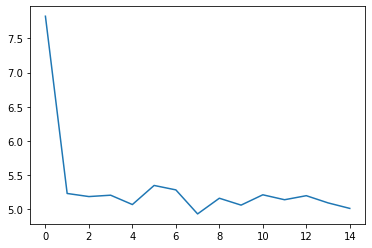

In [13]:
# 可视化 loss
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
log_loss = [loss_log.losses[i] for i in range(0, len(loss_log.losses), 500)]
plt.figure()
plt.plot(log_loss)

## 6、方式2：基于基础API，完成模型的训练与预测
### 6.1 自定义 `train` 函数
通过基础API，自定义 `train` 函数，完成模型的训练。

In [14]:
import paddle.nn.functional as F
losses = []
def train(model):
    model.train()
    optim = paddle.optimizer.Adam(learning_rate=0.01, parameters=model.parameters())
    for epoch in range(epochs):
        for batch_id, data in enumerate(train_loader()):
            x_data = data[0]
            y_data = data[1]
            predicts = model(x_data)
            loss = F.cross_entropy(predicts, y_data)
            loss.backward()
            if batch_id % 500 == 0:
                losses.append(loss.numpy())
                print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, loss.numpy())) 
            optim.step()
            optim.clear_grad()
model = NGramModel(vocab_size, embedding_dim, context_size)
train(model)

epoch: 0, batch_id: 0, loss is: [7.823718]
epoch: 0, batch_id: 500, loss is: [5.5144377]
epoch: 0, batch_id: 1000, loss is: [5.018609]
epoch: 0, batch_id: 1500, loss is: [5.029891]
epoch: 0, batch_id: 2000, loss is: [5.195608]
epoch: 0, batch_id: 2500, loss is: [4.8786173]
epoch: 0, batch_id: 3000, loss is: [5.1473885]
epoch: 0, batch_id: 3500, loss is: [5.0238667]
epoch: 1, batch_id: 0, loss is: [5.059877]
epoch: 1, batch_id: 500, loss is: [5.200143]
epoch: 1, batch_id: 1000, loss is: [5.464027]
epoch: 1, batch_id: 1500, loss is: [5.2350717]
epoch: 1, batch_id: 2000, loss is: [5.284937]
epoch: 1, batch_id: 2500, loss is: [5.041799]
epoch: 1, batch_id: 3000, loss is: [5.275515]
epoch: 1, batch_id: 3500, loss is: [5.121647]


### 6.2 loss可视化
通过可视化loss的曲线，可以看到模型训练的效果。

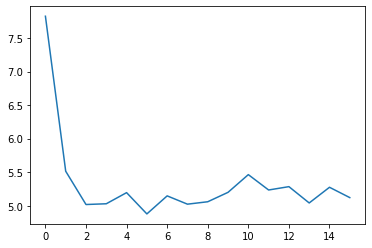

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(losses)

###  6.3 预测
用训练好的模型进行预测。

In [17]:
import random
def test(model):
    model.eval()
    # 从最后10组数据中随机选取1个
    idx = random.randint(len(trigram)-10, len(trigram)-1)
    print('the input words is: ' + trigram[idx][0][0] + ', ' + trigram[idx][0][1])
    x_data = list(map(lambda word: word_to_idx.get(word, 0), trigram[idx][0]))
    x_data = paddle.to_tensor(np.array(x_data))
    predicts = model(x_data)
    predicts = predicts.numpy().tolist()[0]
    predicts = predicts.index(max(predicts))
    print('the predict words is: ' + idx_to_word[predicts])
    y_data = trigram[idx][1]
    print('the true words is: ' + y_data)
test(model)

the input words is: the, complete
the predict words is: works
the true words is: works
